In [29]:
from ase.io import read, extxyz
from glob import glob
from pathlib import Path
import json

import matplotlib.pyplot as plt

In [30]:
paths = glob('runs/nvt-fixed-temp/si*')
paths

['runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-9fb85a0f',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-00f4d1ee',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-3edef378',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-c6b2fa55',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-c87f8b96',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-fc69a0ed',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-c530dbd2',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-e16683d7',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-d8af6f3e',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-526f7ee4',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-8e988302',
 'runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-2bcd06d4',
 'runs/nvt-fixed-temp/si-

In [47]:
path

PosixPath('runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-9fb85a0f')

In [57]:
path = Path(paths[6])
with open(path/'params.json', 'r') as f:
    params = json.load(f)
params

{'file': None,
 'starting_strc': '../0_setup/initial-geometries/si-vacancy-2x2x2.vasp',
 'temperature': 1573.0,
 'timestep': 1,
 'calculator': 'lda',
 'ensemble': 'nvt',
 'temp_tau': 25,
 'stress_tau': 25.0,
 'steps': 40000,
 'seed': 6,
 'bulk_modulus': 98.0,
 'initial_volume': 1376.0,
 'model_type': 'ani',
 'initial_model': None,
 'initial_data': [],
 'ensemble_size': 2,
 'online_training': True,
 'training_epochs': 16,
 'training_batch_size': 32,
 'training_max_size': 512,
 'training_recency_bias': 1.0,
 'training_device': 'cpu',
 'target_error': 0.9,
 'error_history': 8,
 'retrain_freq': 512,
 'min_target_frac': 0.1,
 'n_blending_steps': 0,
 'cascade_commit': '5fda70cf55730fb117bf65924cfd5fae9fd3b0ed',
 'my_commit': '5fda70cf55730fb117bf65924cfd5fae9fd3b0ed',
 'start_time': '2024-10-03T21:01:56.904690'}

In [58]:
atoms = traj[0]
atoms.get_kinetic_energy()

11.892318512039678

In [59]:
v_mean = atoms.get_velocities().mean(0)
v_mean

array([-8.81129385e-19,  5.50705865e-18,  6.38818804e-18])

In [60]:
atoms.set_velocities(atoms.get_velocities() - v_mean)

In [61]:
atoms.get_kinetic_energy()

11.892318512039678

In [62]:
traj = read(path/'md.traj', index=':')
KE = []
KE_v_shifted = []
for atoms in traj:
    v = atoms.get_velocities()
    KE.append(atoms.get_kinetic_energy())

    atoms.set_velocities(v - v.mean(0))
    KE_v_shifted.append(atoms.get_kinetic_energy())

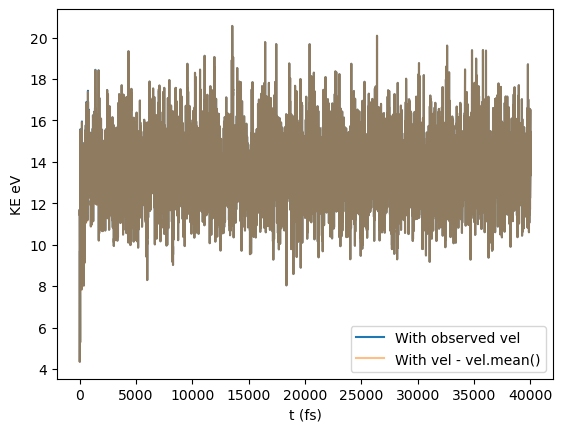

In [63]:
plt.plot(KE, label='With observed vel')
plt.plot(KE_v_shifted, alpha=0.5, label='With vel - vel.mean()')
plt.ylabel('KE eV')
plt.xlabel('t (fs)')
plt.legend();

In [ ]:
traj

In [ ]:
((traj[-1].positions - traj[0].positions)**2).mean()

In [ ]:
delta_com = traj[-1].get_center_of_mass() - traj[0].get_center_of_mass()

In [ ]:
delta_com

In [ ]:
((traj[-1].positions - traj[0].positions - delta_com)**2).mean()